### Team of agents to create a code project based on requirements

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver

In [3]:
class AgentState(TypedDict):
    project_requirements: str
    scaffold_review: str
    scaffolding_saved: bool
    project_filecontents: List[str]
    project_filepaths: str
    messages: Annotated[list[AnyMessage], operator.add]
    scaffolding_version: int
    max_scaffoldings: int

In [135]:
from langchain.tools import tool
import os

@tool
def save_file(file_contents: List[str], file_paths: List[str]) -> str:
    """
    Saves file(s) on local system storage. This can be used for saving both the scaffolding and the generated code files.
    If the directories in the file paths do not exist, they are created automatically.

    Args:
    - file_contents (list[str]): Content of files to create. Should be the same length as file_paths.
    - file_paths (list[str]): Paths of the files to create. Should be the same length as file_contents.

    Returns:
    - str: Comma-separated list of saved file paths.
    """
    # Ensure the base directory exists
    base_directory = "output"
    os.makedirs(base_directory, exist_ok=True)
    
    saved_paths = []

    for file_index in range(len(file_contents)):
        # Prepend the base directory to the file path
        file_path = os.path.join(base_directory, file_paths[file_index])
        
        # Ensure the directory for the file exists
        directory = os.path.dirname(file_path)
        if directory:
            os.makedirs(directory, exist_ok=True)
        
        # Save the file
        with open(file_path, "w") as f:
            f.write(file_contents[file_index])
        
        saved_paths.append(file_path)
    
    return ", ".join(saved_paths)

In [136]:
model = ChatOpenAI(model="gpt-4o-mini",temperature=0)
model = model.bind_tools([save_file])

In [137]:
SCAFFOLDER_PROMPT = """You are a senior dev tasked with scaffolding the project structure based on the input requirements.
Generate the best possible project structure based on standard rules of the programming language mentioned in the input. 
Create file names and directories which best suits the project requirements. 
The project strcture should be a JSON with following structure
project_filepaths:["file1.extension","folder/file2.extension"]
project_filecontents:["content of file1","content of file 2"]

Each file has a comment which shows it is generated by scaffolding. The readme should be properly created but concise and precise. 
Guardrail: do not generate any file which is not plain-text like images 

If the user provides critique, respond with a revised project structure. 
If structure/scaffolding review is passed, directly save the scaffolded files to system storage

"""

TECH_LEAD_REVIEWER_PROMPT = """ You are an expert senior coder and tech lead. You have end-to-end software development experience of 10+ years. 
You are responsible for reviewing the project structure: project_filepaths(JSON). If review of the project structure follows standard guidelines for 
scalability, security and efficiency and has adherence to the input requirements, return review as STRUCTURE_REVIEW: GOOD otherwise provide feedback on updates needed
in the structure.

Project structure generated by scaffolder: {project_structure}
If structure/scaffolding review is passed, directly save the scaffolded files to system storage

"""

In [138]:
from langchain_core.pydantic_v1 import BaseModel

class ProjectStructure(BaseModel):
    project_filepaths: List[str]
    project_filecontents: List[str]
    
def scaffolder_node(state: AgentState):
    response = model.with_structured_output(ProjectStructure,method="json_mode").invoke([
        SystemMessage(content=SCAFFOLDER_PROMPT.format(project_requirements=state['project_requirements'])),
        HumanMessage(content=state['project_requirements'])
    ])
    # print(response)
    return {"project_filepaths": ",".join(response.project_filepaths),'messages': [response],'scaffolding_version': state.get("scaffolding_version", 1) + 1}

In [139]:
def tech_lead_reviewer_node(state: AgentState):
    messages = [
        SystemMessage(content=TECH_LEAD_REVIEWER_PROMPT), 
        HumanMessage(content=state['project_filepaths'])
    ]
    response = model.invoke(messages)
    
    return {"scaffold_review": response.content,'messages': [response]}

In [145]:
def save_scaffolding(state):
    tool_calls = state['messages'][-1].tool_calls
    if len(tool_calls) == 0:
        tool_calls = state['messages'][-2].tool_calls
    print("tool_calls",tool_calls)

    for t in tool_calls:
        print(f"Calling tool: {t} with args {t['args']}")
        result = save_file.invoke(t['args'])
        state['scaffolding_saved'] = True
        return {'messages': [ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result))]}
    
    state['scaffolding_saved'] = True
        

In [146]:
def review_scaffolding(state):
    print("review_scaffolding")
    if state["scaffolding_version"] > state["max_scaffoldings"]:
        print("Max scaffoldings reached, exitting...")
        return END
    
    if "STRUCTURE_REVIEW: GOOD" in state['scaffold_review']:
        if state['scaffolding_saved'] == True:
            return END
        else:
            print("SAVING SCAFFOLDING")
            return "save_scaffolding"
    else:
        return "scaffolder"

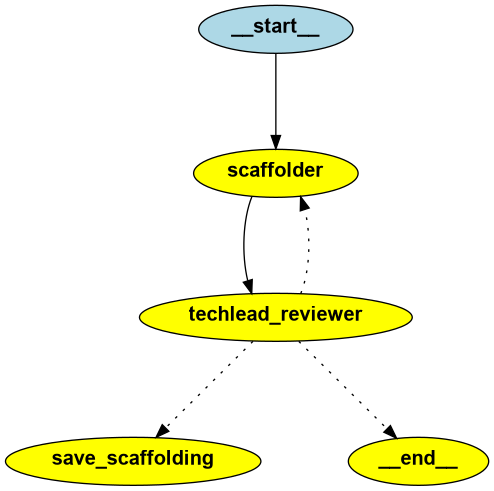

In [147]:
builder = StateGraph(AgentState)

builder.add_node("scaffolder", scaffolder_node)
builder.add_node("techlead_reviewer", tech_lead_reviewer_node)
builder.add_node("save_scaffolding", save_scaffolding)

builder.add_edge("scaffolder", "techlead_reviewer")
builder.set_entry_point("scaffolder")

builder.add_conditional_edges(
    "techlead_reviewer", 
    review_scaffolding, 
    {END: END, "save_scaffolding": "save_scaffolding","scaffolder": "scaffolder"}
)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [148]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'project_requirements': "Create a CRUD app for TODOs in python using tkinter as GUI and sqlite as database",
    "max_scaffoldings": 5,
    "scaffolding_saved": False,
    "scaffolding_version": 1,
}, thread):
    print(s)

{'scaffolder': {'project_filepaths': 'README.md,main.py,database.py,todo_app.py,requirements.txt,gui.py,models/todo.py,controllers/todo_controller.py', 'messages': [ProjectStructure(project_filepaths=['README.md', 'main.py', 'database.py', 'todo_app.py', 'requirements.txt', 'gui.py', 'models/todo.py', 'controllers/todo_controller.py'], project_filecontents=["# README.md\nThis is a simple CRUD application for managing TODOs using Python's Tkinter for the GUI and SQLite for the database. \n\n## Features\n- Create, Read, Update, and Delete TODOs\n- Simple and intuitive user interface\n\n## Requirements\n- Python 3.x\n- Tkinter\n- SQLite\n\n## How to Run\n1. Install the required packages listed in requirements.txt\n2. Run `main.py` to start the application.", "# main.py\n# This file is generated by scaffolding.\nimport tkinter as tk\nfrom gui import TodoApp\n\nif __name__ == '__main__':\n    root = tk.Tk()\n    app = TodoApp(root)\n    root.mainloop()", "# database.py\n# This file is gener